In [1]:
import matplotlib.pyplot as plt
#import seaborn
#seaborn.set()  # this makes plots pretty. but it also makes histograms confusing
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import cross_validation as cv

from skll import metrics
from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

import xgboost

import json

import data_utils

In [2]:
train_init = pd.read_csv('../../data/train.csv')
test_init = pd.read_csv('../../data/test.csv')

In [3]:
constant_cols = (train_init.columns[train_init.max() == train_init.min()])

In [4]:
train = train_init.drop(constant_cols, axis=1).drop(['ID'], axis=1)
test = test_init.drop(constant_cols, axis=1)

In [5]:
roc_scorer = make_scorer(roc_auc_score)
X = train.drop(['TARGET'], axis=1).values
y = train.TARGET.values

In [6]:
clf = Pipeline([
  ('feature_preselection', RFE(RandomForestRegressor(n_estimators=30, n_jobs=-1), 50, step=25)),
  ('feature_generation', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
  ('feature_selection', RFE(RandomForestRegressor(n_estimators=30, n_jobs=-1), 300, step=250)),
  ('classification', RandomForestRegressor(n_estimators=300, n_jobs=-1))
])

In [7]:
clf.fit_transform(X, y)

/Library/Python/2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[  2.30000000e+01,   3.92051700e+04,   4.60000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.40000000e+01,   4.92780300e+04,   6.80000000e+01, ...,
          4.38032409e+06,   0.00000000e+00,   0.00000000e+00],
       [  2.30000000e+01,   6.73337700e+04,   4.60000000e+01, ...,
          1.21200786e+04,   2.02001310e+05,   1.39380904e+05],
       ..., 
       [  2.30000000e+01,   7.40281500e+04,   4.60000000e+01, ...,
          0.00000000e+00,   2.22084450e+05,   2.22084450e+05],
       [  2.50000000e+01,   8.42781600e+04,   5.00000000e+01, ...,
          1.46643998e+05,   2.52834480e+05,   2.17437653e+05],
       [  4.60000000e+01,   1.17310979e+05,   9.20000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

## Save results

Extract composite features names (var15 * var38 becomes `var15__var38`) and save them with their feature importances as calculated by the last RFR in the pipeline.

In [12]:
cols = train.columns.values
preselected_cols = cols[clf.named_steps['feature_preselection'].support_]
pwrs = clf.named_steps['feature_generation'].powers_
sprt = clf.named_steps['feature_selection'].support_

In [17]:
selected_cols = np.array(["__".join(filter(None, s)) for s in preselected_cols*pwrs])[sprt]
ft_importance = clf.named_steps['classification'].feature_importances_

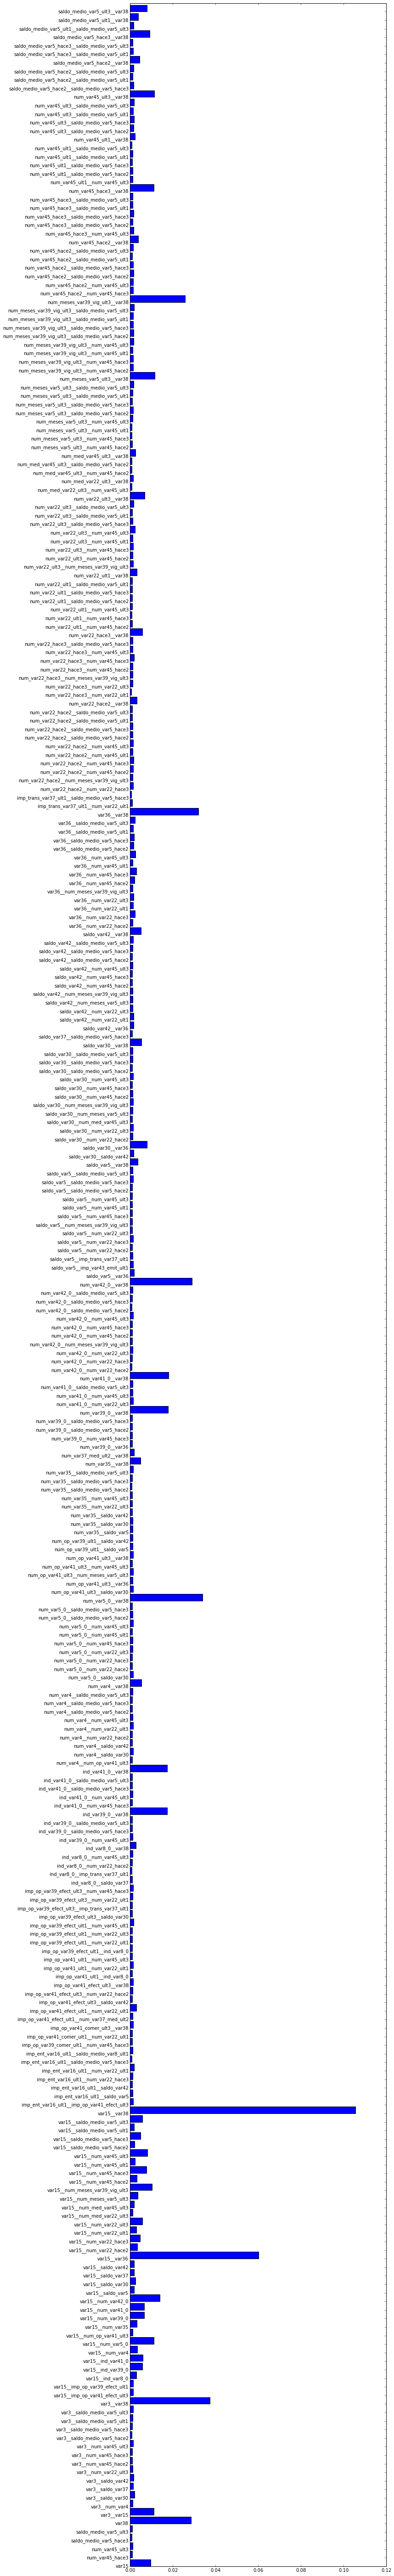

In [27]:
plt.figure(figsize=(10, 100))
plt.barh(range(len(ft_importance)), ft_importance)
plt.yticks(range(len(ft_importance)), selected_cols)
plt.savefig('generated/polynomial_features_importance.png', bbox_inches='tight')

In [30]:
json.dump(dict(zip(selected_cols, ft_importance)), open('generated/json_dumps/polynomial_ft.json', 'w'), indent=1)